<a href="https://colab.research.google.com/github/mujahid345/BIke-sharing/blob/main/Bike_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u>  Seoul Bike Sharing Demand Prediction </u></b>

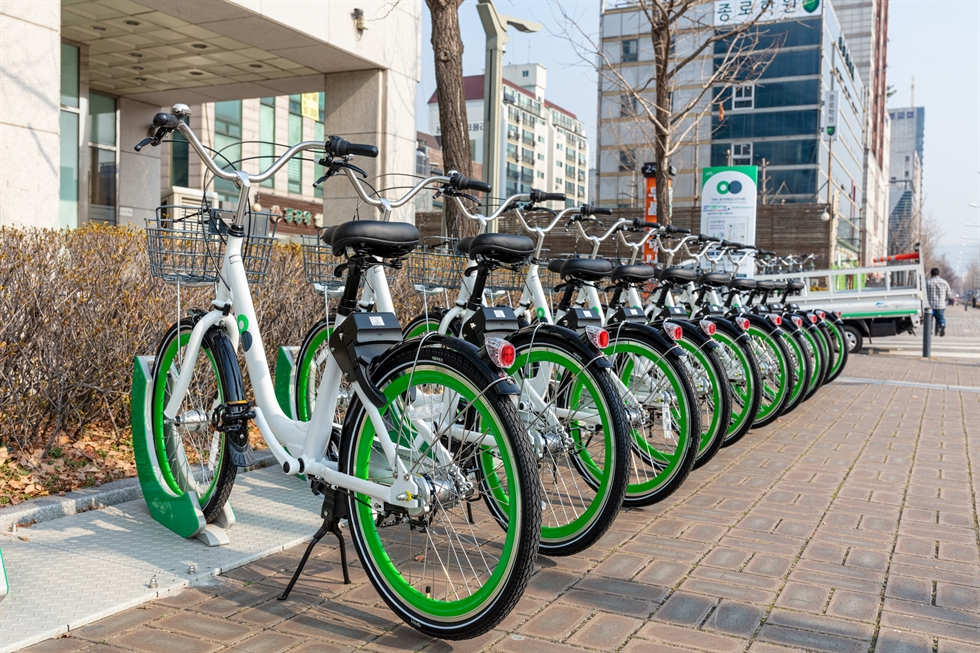

## <b> Problem Description </b>

### Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes

## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [1]:
import pandas as pd
import numpy as np
from numpy import math
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.dpi'] = 100

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing Dataset with unicode_escape to avoid unicode Decode error while importing
df = pd.read_csv("/content/drive/MyDrive/Cohort Rishi/ML/SeoulBikeData.csv", encoding = 'unicode_escape')

In [4]:
df.head()  # ... inspecting the first 5 rows of data 

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
df.info()  #.. inspecting for any null values, data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [6]:
df.describe(include =['object'])  # .. Summary of non numeric datasets

,Date,Seasons,Holiday,Functioning Day
count,8760,8760,8760,8760
unique,365,4,2,2
top,01/12/2017,Spring,No Holiday,Yes
freq,24,2208,8328,8465


In [7]:
df['Holiday'].value_counts()  # .... Checking for unique values of the Holiday Column

No Holiday    8328
Holiday        432
Name: Holiday, dtype: int64

In [8]:
len(df[df.duplicated()])  # ... Checking for duplicate values

0

In [9]:
# Creating variable wiht the name of categorical columns
categorical_variables = df.describe(include = 'object').columns
categorical_variables

Index(['Date', 'Seasons', 'Holiday', 'Functioning Day'], dtype='object')

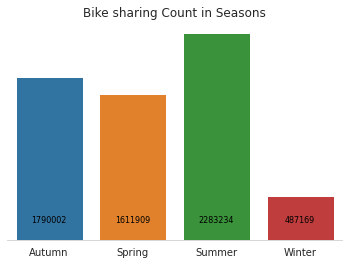

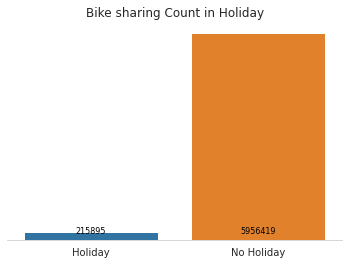

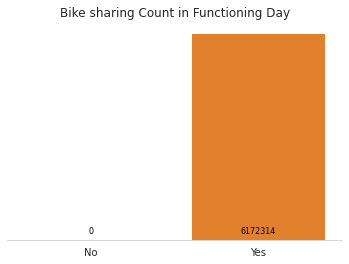

In [10]:
# Visualizing the Total number of rented bikes/ hr for against Seasons, Holidays  Functioning days
sns.set_style("whitegrid")
for i in categorical_variables[1:]:  
  fig = plt.figure(figsize = (6,4))
  ax = fig.gca()
  
  if df[i].nunique() < 5:      #.... ensuring categorical variable with not more than 5 unique values are considerd
    df_sample = df.groupby([i]).sum().reset_index().iloc[:,:2]
    sns.barplot(data = df_sample, x = df_sample[i], y = 'Rented Bike Count',ci = None, ax = ax)  # ... Creating the bargrahph 
    plt.title('Bike sharing Count in ' + i)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine(left = True)
    plt.yticks([])

    for j in range(len((df[i].unique()))):
      plt.text(x = j , y = 200000, s = df_sample.loc[j,'Rented Bike Count'],color='black', fontsize=8, horizontalalignment='center')




*   Most number of Bikes are rented in **Summer**, followed by **Autumn** and **Spring** and **Winter**

*   People prefer booking bikes on **Working days** more than the **Holidays**

*   All the bikes were rented on the **functioning day**

In [11]:
# Creating function to change the data format of the dataset
import datetime
def conv_dates_series(df, col, old_date_format, new_date_format):

    df[col] = pd.to_datetime(df[col], format=old_date_format).dt.strftime(new_date_format)
    
    return df

In [12]:
old_date_format= '%d/%m/%Y'   #.... current format of date not compatible for further EDA
new_date_format= "%Y-%m-%d"   #.... new format of date compatible for further EDA

conv_dates_series(df, 'Date', old_date_format, new_date_format)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [13]:
# Extracting the Date, Month and Year of each Date from Datframe
df['month'] = None
df['year'] = None
df['day'] = None

for i in range(len(df.Date)):
  df['month'][i] = df['Date'][i][5:7]
  df['year'][i]  = df['Date'][i][:4]
  df['day'][i]  = df['Date'][i][8:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [14]:
df.head()  # ... inspecting the newly created columns

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,month,year,day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,01
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,01
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,01
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,01
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,01


In [15]:
# Visualzing total Bikes rented in each month
df_by_month = df.groupby(['month']).sum().reset_index().iloc[:,:2]

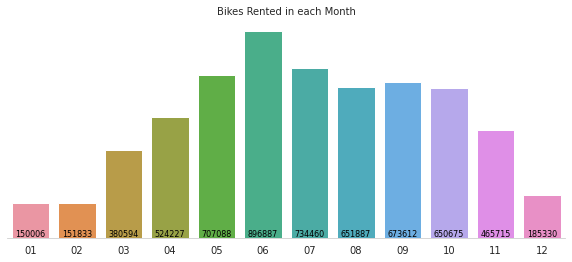

In [16]:
fig  = plt.figure(figsize = (10,4))
sns.barplot(data= df_by_month, x = 'month', y = 'Rented Bike Count')
plt.title ('Bikes Rented in each Month', fontsize  = 10)
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
sns.despine(left = True)

for i in range(12):
  plt.text(x=i, y=8000, s=df_by_month.loc[i,'Rented Bike Count'], color='black', fontsize=8, horizontalalignment='center')



*   June is the most preferred Month for bike sharing with around **896K** bike shared.
*   July and May are the second best with total sharing of **734K** and **707K**.

*   Bike sharing was least in December and January with , **185K** and **150K**.

